# Iris 데이터를 활용한 랜덤포레스트 & 부스팅

## 0. Iris 데이터 및 패키지 불러오기

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
!pip3 install xgboost
import xgboost
%matplotlib inline

from sklearn import datasets

iris = datasets.load_iris()

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## 1. Iris 데이터 시각화

In [2]:
# Iris 데이터를 pandas의 dataframe으로 만들고, 데이터 형태를 살펴보자.
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

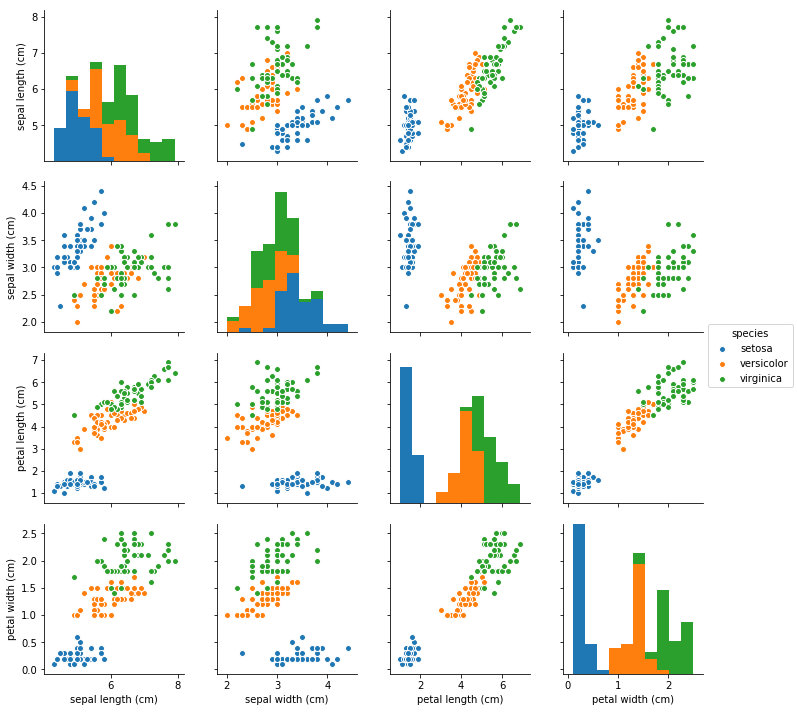

In [3]:
# iris 데이터의 species는 classification을 위해 정수 형태(0, 1, 2)로 되어 있음
# 시각화를 위해 species integer를 species name으로 바꾼 새로운 열을 df에 추가
df['species'] = np.array([iris.target_names[i] for i in iris.target])

# 시각화 라이브러리인 seaborn으로 pairplot을 그려보자.
sns.pairplot(df, hue='species')

## 2. train set, test set 만들기

In [4]:
# sklearn에서 train_test_split 함수 불러오기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[iris.feature_names], iris.target, 
                                                    test_size=0.25, stratify=iris.target, random_state=123456)

# train_test_split(x, y, test_size, stratify, random_state)
# test_size : 테스트 데이터 사이즈
# train_size : 트레인 데이터 사이즈
# stratify : 클래스 라벨
# random_state : 난수 시드

## 3. 랜덤포레스트 모델 만들기

In [8]:
# sklearn에서 RandomForestClassifier 함수 불러오기
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
# n_estimators : 생성할 트리의 개수
# oob_score : out-of-bag score, 예측이 얼마나 정확한가에 대한 추정을 수치로 나타낸 것

rf.fit(X_train, y_train)
# rf.fit(features, targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=123456, verbose=0,
            warm_start=False)

## 4. test set에 적합하기

In [9]:
# sklearn에서 accuracy_score 함수 불러오기
from sklearn.metrics import accuracy_score

predicted = rf.predict(X_test) # rf 모델에 X_test를 넣고 그 예측값을 predicted에 저장
accuracy = accuracy_score(y_test, predicted) # 실제 데이터와 예측값이 일치하는 비율

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.946
Mean accuracy score: 0.921


## 5. confusion matrix로 분류 결과 시각화

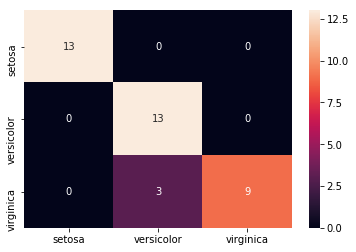

In [10]:
# sklearn에서 confusion_matrix 함수 불러오기
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=iris.target_names, index=iris.target_names)
# confusion_matrix는 라벨이 있는 경우 분류 모델을 평가하는 방법
# column은 predicted, row는 y_test
sns.heatmap(cm, annot=True) # sns 라이브러리에 있는 heatmap으로 cm을 시각화

# setosa는 정확히 분류해 내고 있지만, versicolor와 virginica의 구별은 명확하지 않다.

## 6. xgboost 모델 만들기

In [14]:
xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=2)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

## 7. test set에 적합하기

In [20]:
predicted_xgb = xgb.predict(X_test) # xgb 모델에 X_test를 넣고 그 예측값을 predicted에 저장
accuracy_xgb = accuracy_score(y_test, predicted_xgb) # 실제 데이터와 예측값이 일치하는 비율

print(f'Mean accuracy score: {accuracy_xgb:.3}')

Mean accuracy score: 0.947


C:\Users\yuniv\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## 8. confusion matrix로 분류 결과 시각화

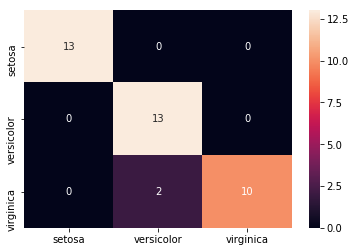

In [18]:
cm_xgb = pd.DataFrame(confusion_matrix(y_test, predicted_xgb), columns=iris.target_names, index=iris.target_names)
sns.heatmap(cm_xgb, annot=True) # sns 라이브러리에 있는 heatmap으로 cm_xgb를 시각화

# 랜덤포레스트보다 예측 성능이 좋아졌다